# PATSTAT Schema Explorer - TIP Environment

Dieses Notebook bietet eine umfassende Einführung in die PATSTAT Datenbank-Struktur und zeigt verschiedene Methoden zur Schema-Exploration.

## Inhalt
1. Grundlegende Verbindung und Setup
2. Schema-Übersicht mit SQLAlchemy Inspector
3. ORM-Modelle erkunden
4. Wichtige PATSTAT-Tabellen im Detail
5. Beziehungen zwischen Tabellen visualisieren
6. Praktische Abfrage-Beispiele
7. Hilfsfunktionen für die tägliche Arbeit

## 1. Setup und Import

In [6]:
# Standard Imports
import pandas as pd
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# PATSTAT TIP Library
from epo.tipdata.patstat import PatstatClient
from epo.tipdata.patstat.database.models import (
    TLS201_APPLN, TLS202_APPLN_TITLE, TLS206_PERSON,
    TLS207_PERS_APPLN, TLS209_APPLN_IPC, TLS211_PAT_PUBLN,
    TLS212_CITATION, TLS224_APPLN_CPC
)
from sqlalchemy import inspect, MetaData, Table, text, func
from sqlalchemy.orm import Query

# Visualisierung
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

# Display Optionen
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', 50)

# PATSTAT Client initialisieren
patstat = PatstatClient(env='PROD')
db = patstat.orm()
engine = db.bind

print("✅ Setup erfolgreich abgeschlossen")
print(f"📅 Datum: {datetime.now().strftime('%Y-%m-%d %H:%M')}")
print(f"🔗 PATSTAT Client verbunden")

✅ Setup erfolgreich abgeschlossen
📅 Datum: 2025-09-18 13:17
🔗 PATSTAT Client verbunden


## 2. Datenbank-Verbindung testen

In [7]:
# Verbindung testen mit PATSTAT Client
try:
    # Einfache Test-Abfrage über ORM
    test_query = db.query(TLS201_APPLN.appln_id).limit(1)
    result = test_query.first()
    print("✅ Datenbankverbindung erfolgreich!")

    # PATSTAT Zugriff prüfen
    count_query = db.query(func.count(TLS201_APPLN.appln_id)).filter(TLS201_APPLN.appln_id < 100)
    count_result = count_query.scalar()
    print(f"✅ PATSTAT Zugriff funktioniert (Test-Count: {count_result})")

except Exception as e:
    print(f"❌ Fehler bei der Verbindung: {e}")

✅ Datenbankverbindung erfolgreich!
✅ PATSTAT Zugriff funktioniert (Test-Count: 100)


## 3. Schema-Übersicht mit SQLAlchemy Inspector

In [9]:
# Schema-Übersicht mit PATSTAT Client
print("📊 PATSTAT Schema-Übersicht\n")

# Global Tables (Hauptdatenbank)
global_tables = patstat.list_global_tables()
print(f"📁 GLOBAL Tables: {len(global_tables)} Tabellen")
print("="*50)

# Kategorisiere Global Tables
tls_categories = {
    'Applications (201-203)': [t for t in global_tables if t.startswith('tls20')],
    'Publications (211-216)': [t for t in global_tables if t.startswith('tls21')],
    'Classifications (224-230)': [t for t in global_tables if t.startswith('tls22')],
    'Legal Events (231)': [t for t in global_tables if t.startswith('tls23')],
    'Reference Tables (801-903)': [t for t in global_tables if t.startswith('tls8') or t.startswith('tls9')]
}

for category, tables in tls_categories.items():
    if tables:
        print(f"\n📂 {category}:")
        for table in sorted(tables)[:8]:  # Erste 8 anzeigen
            print(f"   • {table}")
        if len(tables) > 8:
            print(f"   ... und {len(tables)-8} weitere")

# Register Tables
register_tables = patstat.list_register_tables()
print(f"\n📁 REGISTER Tables: {len(register_tables)} Tabellen")
print(f"   (Erste 10: {', '.join(register_tables[:10])}...)")

📊 PATSTAT Schema-Übersicht

📁 GLOBAL Tables: 28 Tabellen

📂 Applications (201-203):
   • tls201_appln
   • tls202_appln_title
   • tls203_appln_abstr
   • tls204_appln_prior
   • tls205_tech_rel
   • tls206_person
   • tls207_pers_appln
   • tls209_appln_ipc

📂 Publications (211-216):
   • tls210_appln_n_cls
   • tls211_pat_publn
   • tls212_citation
   • tls214_npl_publn
   • tls215_citn_categ
   • tls216_appln_contn

📂 Classifications (224-230):
   • tls222_appln_jp_class
   • tls224_appln_cpc
   • tls225_docdb_fam_cpc
   • tls226_person_orig
   • tls227_pers_publn
   • tls228_docdb_fam_citn
   • tls229_appln_nace2

📂 Legal Events (231):
   • tls230_appln_techn_field
   • tls231_inpadoc_legal_event

📂 Reference Tables (801-903):
   • tls801_country
   • tls803_legal_event_code
   • tls901_techn_field_ipc
   • tls902_ipc_nace2
   • tls904_nuts

📁 REGISTER Tables: 38 Tabellen
   (Erste 10: reg101_appln, reg102_pat_publn, reg110_title, reg118_prev_filed_appln, reg103_ipc, reg125_appeal,

## 4. Die wichtigsten PATSTAT-Tabellen im Detail

In [10]:
# Definiere die Kern-Tabellen von PATSTAT
core_tables = {
    'Applications': {
        'tls201_appln': 'Haupttabelle für Patentanmeldungen',
        'tls202_appln_title': 'Titel der Anmeldungen',
        'tls203_appln_abstr': 'Abstracts der Anmeldungen'
    },
    'Publications': {
        'tls211_pat_publn': 'Publikationen zu Anmeldungen'
    },
    'Persons': {
        'tls206_person': 'Bereinigte Personendaten',
        'tls207_pers_appln': 'Verknüpfung Person-Anmeldung',
        'tls226_person_orig': 'Original Personendaten',
        'tls227_pers_publn': 'Verknüpfung Person-Publikation'
    },
    'Classifications': {
        'tls209_appln_ipc': 'IPC Klassifikationen',
        'tls224_appln_cpc': 'CPC Klassifikationen',
        'tls230_appln_techn_field': 'Technologiefelder'
    },
    'Citations': {
        'tls212_citation': 'Zitierungen',
        'tls215_citn_categ': 'Zitierungs-Kategorien',
        'tls214_npl_publn': 'Non-Patent Literature'
    },
    'Relations': {
        'tls204_appln_prior': 'Prioritäten',
        'tls216_appln_contn': 'Fortsetzungen/Teilungen',
        'tls205_tech_rel': 'Technische Beziehungen'
    },
    'Legal Events': {
        'tls231_inpadoc_legal_event': 'Rechtliche Ereignisse',
        'tls803_legal_event_code': 'Event Code Definitionen'
    }
}

# Alle verfügbaren Tabellen aus PATSTAT abrufen
all_available_tables = patstat.list_global_tables() + patstat.list_register_tables()

# Erstelle DataFrame für Übersicht
table_overview = []
for category, tables in core_tables.items():
    for table_name, description in tables.items():
        if table_name in all_available_tables:
            table_overview.append({
                'Kategorie': category,
                'Tabelle': table_name,
                'Beschreibung': description,
                'Vorhanden': '✅'
            })
        else:
            table_overview.append({
                'Kategorie': category,
                'Tabelle': table_name,
                'Beschreibung': description,
                'Vorhanden': '❌'
            })

df_overview = pd.DataFrame(table_overview)
print("\n📋 PATSTAT Kern-Tabellen Übersicht:")
print("="*80)
display(df_overview)


📋 PATSTAT Kern-Tabellen Übersicht:


,Kategorie,Tabelle,Beschreibung,Vorhanden
0,Applications,tls201_appln,Haupttabelle für Patentanmeldungen,✅
1,Applications,tls202_appln_title,Titel der Anmeldungen,✅
2,Applications,tls203_appln_abstr,Abstracts der Anmeldungen,✅
3,Publications,tls211_pat_publn,Publikationen zu Anmeldungen,✅
4,Persons,tls206_person,Bereinigte Personendaten,✅
5,Persons,tls207_pers_appln,Verknüpfung Person-Anmeldung,✅
6,Persons,tls226_person_orig,Original Personendaten,✅
7,Persons,tls227_pers_publn,Verknüpfung Person-Publikation,✅
8,Classifications,tls209_appln_ipc,IPC Klassifikationen,✅
9,Classifications,tls224_appln_cpc,CPC Klassifikationen,✅


## 5. Schema-Details für ausgewählte Tabellen

In [11]:
def analyze_table_schema_orm(model_class, limit=15):
    """Analysiert das Schema einer ORM-Tabelle"""

    table_name = model_class.__tablename__

    print(f"\n{'='*80}")
    print(f"📊 Schema-Analyse für: {table_name}")
    print(f"{'='*80}")

    # ORM Spalten-Informationen
    columns = model_class.__table__.columns
    print(f"\n📝 Spalten ({len(columns)} insgesamt, erste {min(limit, len(columns))} angezeigt):")
    print("-"*60)

    col_data = []
    for i, col in enumerate(list(columns)[:limit], 1):
        col_data.append({
            'Nr': i,
            'Spaltenname': col.name,
            'Datentyp': str(col.type),
            'Nullable': '✓' if col.nullable else '✗',
            'Primary Key': '🔑' if col.primary_key else ''
        })

    df_cols = pd.DataFrame(col_data)
    display(df_cols)

    # Primary Keys
    pk_cols = [col.name for col in columns if col.primary_key]
    if pk_cols:
        print(f"\n🔑 Primary Key(s): {', '.join(pk_cols)}")

    # Foreign Keys
    fk_cols = [col for col in columns if col.foreign_keys]
    if fk_cols:
        print(f"\n🔗 Foreign Keys ({len(fk_cols)}):")
        for col in fk_cols[:5]:  # Erste 5 FKs anzeigen
            for fk in col.foreign_keys:
                print(f"   • {col.name} → {fk.column}")

    return columns

# Analysiere die wichtigste Tabelle: tls201_appln
print("Analysiere TLS201_APPLN (Patentanmeldungen):")
columns_appln = analyze_table_schema_orm(TLS201_APPLN)

Analysiere TLS201_APPLN (Patentanmeldungen):

📊 Schema-Analyse für: tls201_appln

📝 Spalten (27 insgesamt, erste 15 angezeigt):
------------------------------------------------------------


,Nr,Spaltenname,Datentyp,Nullable,Primary Key
0,1,appln_id,INTEGER,✗,🔑
1,2,appln_auth,VARCHAR,✓,
2,3,appln_nr,VARCHAR,✓,
3,4,appln_kind,VARCHAR,✓,
4,5,appln_filing_date,DATE,✓,
5,6,appln_filing_year,INTEGER,✓,
6,7,appln_nr_epodoc,VARCHAR,✓,
7,8,appln_nr_original,VARCHAR,✓,
8,9,ipr_type,VARCHAR,✓,
9,10,receiving_office,VARCHAR,✓,



🔑 Primary Key(s): appln_id


In [12]:
# Analysiere weitere wichtige Tabellen
important_models = [
    (TLS211_PAT_PUBLN, 'Publikationen'),
    (TLS206_PERSON, 'Personen/Anmelder'),
    (TLS209_APPLN_IPC, 'IPC Klassifikationen')
]

for model_class, description in important_models:
    print(f"\nAnalysiere {model_class.__tablename__} ({description}):")
    analyze_table_schema_orm(model_class, limit=10)


Analysiere tls211_pat_publn (Publikationen):

📊 Schema-Analyse für: tls211_pat_publn

📝 Spalten (10 insgesamt, erste 10 angezeigt):
------------------------------------------------------------


,Nr,Spaltenname,Datentyp,Nullable,Primary Key
0,1,pat_publn_id,INTEGER,✗,🔑
1,2,publn_auth,VARCHAR,✓,
2,3,publn_nr,VARCHAR,✓,
3,4,publn_nr_original,VARCHAR,✓,
4,5,publn_kind,VARCHAR,✓,
5,6,appln_id,INTEGER,✓,
6,7,publn_date,DATE,✓,
7,8,publn_lg,VARCHAR,✓,
8,9,publn_first_grant,VARCHAR,✓,
9,10,publn_claims,INTEGER,✓,



🔑 Primary Key(s): pat_publn_id

🔗 Foreign Keys (1):
   • appln_id → tls201_appln.appln_id

Analysiere tls206_person (Personen/Anmelder):

📊 Schema-Analyse für: tls206_person

📝 Spalten (17 insgesamt, erste 10 angezeigt):
------------------------------------------------------------


,Nr,Spaltenname,Datentyp,Nullable,Primary Key
0,1,person_id,INTEGER,✗,🔑
1,2,person_name,VARCHAR,✓,
2,3,person_name_orig_lg,VARCHAR,✓,
3,4,person_address,VARCHAR,✓,
4,5,person_ctry_code,VARCHAR,✓,
5,6,nuts,VARCHAR,✓,
6,7,nuts_level,INTEGER,✓,
7,8,doc_std_name_id,INTEGER,✓,
8,9,doc_std_name,VARCHAR,✓,
9,10,psn_id,INTEGER,✓,



🔑 Primary Key(s): person_id

Analysiere tls209_appln_ipc (IPC Klassifikationen):

📊 Schema-Analyse für: tls209_appln_ipc

📝 Spalten (7 insgesamt, erste 7 angezeigt):
------------------------------------------------------------


,Nr,Spaltenname,Datentyp,Nullable,Primary Key
0,1,appln_id,INTEGER,✗,🔑
1,2,ipc_class_symbol,VARCHAR,✓,
2,3,ipc_class_level,VARCHAR,✓,
3,4,ipc_version,DATE,✓,
4,5,ipc_value,VARCHAR,✓,
5,6,ipc_position,VARCHAR,✓,
6,7,ipc_gener_auth,VARCHAR,✓,



🔑 Primary Key(s): appln_id

🔗 Foreign Keys (1):
   • appln_id → tls201_appln.appln_id


## 6. Beziehungen zwischen Tabellen visualisieren

In [13]:
# Sammle ORM Foreign Key Beziehungen
def get_orm_relationships():
    """Extrahiert FK-Beziehungen von ORM-Modellen"""
    relationships = []

    # Wichtige ORM-Modelle
    models = [
        TLS201_APPLN, TLS202_APPLN_TITLE, TLS206_PERSON,
        TLS207_PERS_APPLN, TLS209_APPLN_IPC, TLS211_PAT_PUBLN,
        TLS212_CITATION, TLS224_APPLN_CPC
    ]

    for model in models:
        table = model.__table__
        for col in table.columns:
            if col.foreign_keys:
                for fk in col.foreign_keys:
                    relationships.append({
                        'from_table': table.name,
                        'from_column': col.name,
                        'to_table': fk.column.table.name,
                        'to_column': fk.column.name
                    })

    return pd.DataFrame(relationships)

# Beziehungen analysieren
df_relationships = get_orm_relationships()

print("\n🔗 Tabellen-Beziehungen (Foreign Keys):")
print("="*80)
display(df_relationships.head(15))

# Zentralität der Tabellen
from_counts = df_relationships['from_table'].value_counts()
to_counts = df_relationships['to_table'].value_counts()

print(f"\n🎯 Zentrale Tabellen (viele eingehende Referenzen):")
for table, count in to_counts.head(3).items():
    print(f"   • {table}: {count} eingehende Referenzen")

print(f"\n🔄 Tabellen mit vielen ausgehenden Referenzen:")
for table, count in from_counts.head(3).items():
    print(f"   • {table}: {count} ausgehende Referenzen")


🔗 Tabellen-Beziehungen (Foreign Keys):


,from_table,from_column,to_table,to_column
0,tls202_appln_title,appln_id,tls201_appln,appln_id
1,tls207_pers_appln,person_id,tls206_person,person_id
2,tls207_pers_appln,appln_id,tls201_appln,appln_id
3,tls209_appln_ipc,appln_id,tls201_appln,appln_id
4,tls211_pat_publn,appln_id,tls201_appln,appln_id
5,tls212_citation,pat_publn_id,tls211_pat_publn,pat_publn_id
6,tls224_appln_cpc,appln_id,tls201_appln,appln_id



🎯 Zentrale Tabellen (viele eingehende Referenzen):
   • tls201_appln: 5 eingehende Referenzen
   • tls206_person: 1 eingehende Referenzen
   • tls211_pat_publn: 1 eingehende Referenzen

🔄 Tabellen mit vielen ausgehenden Referenzen:
   • tls207_pers_appln: 2 ausgehende Referenzen
   • tls202_appln_title: 1 ausgehende Referenzen
   • tls209_appln_ipc: 1 ausgehende Referenzen


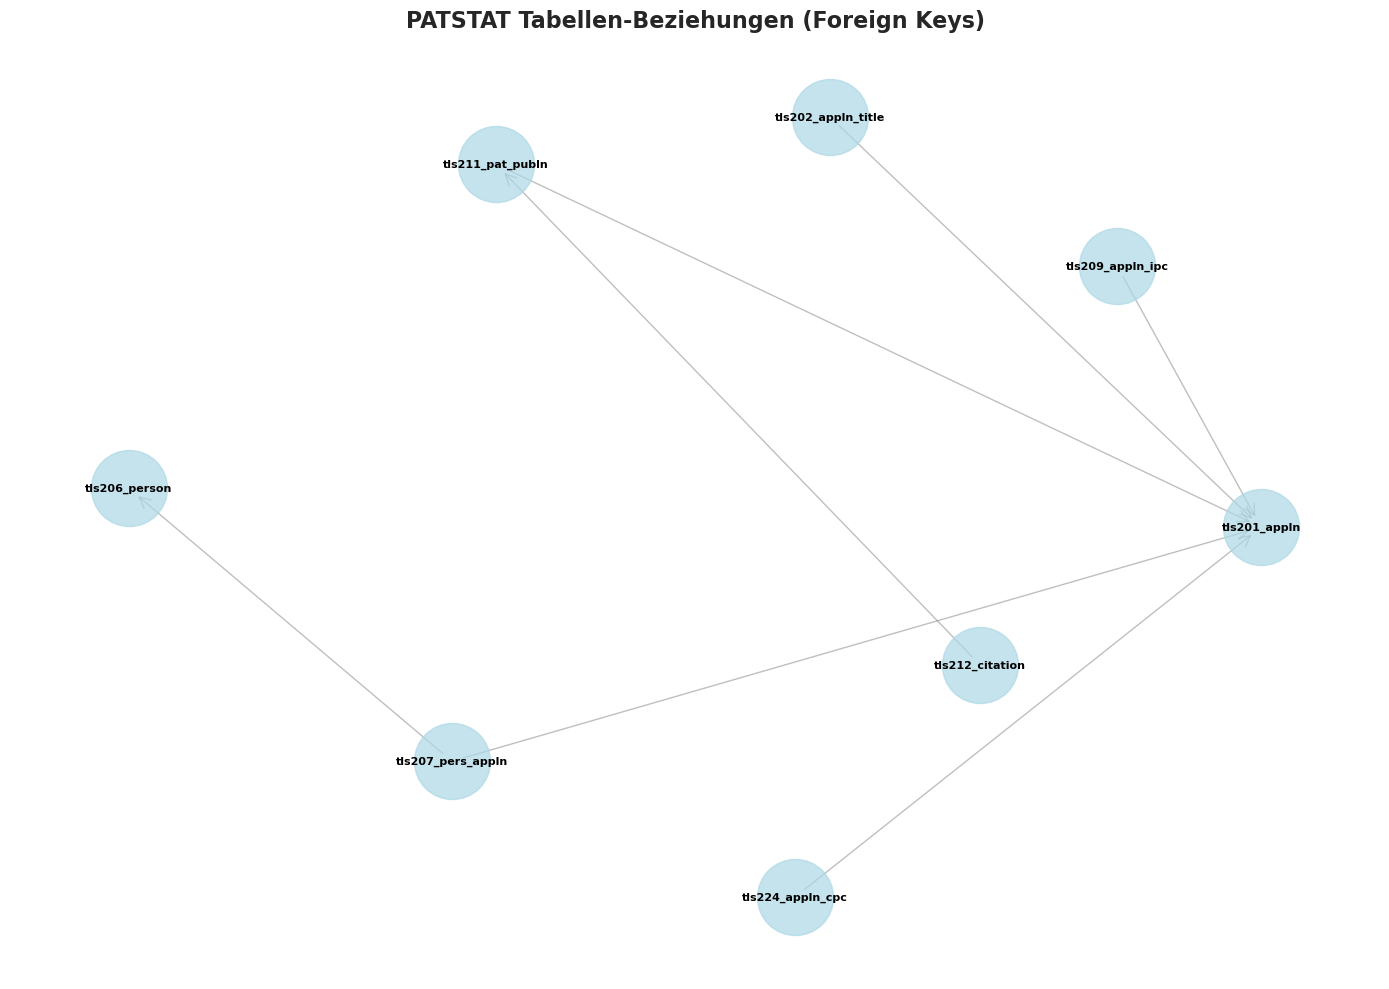


📊 Netzwerk-Statistiken:
  • Anzahl Tabellen (Knoten): 8
  • Anzahl Beziehungen (Kanten): 7

🎯 Zentrale Tabellen (viele eingehende Referenzen):
  • tls201_appln: 5 eingehende Referenzen
  • tls206_person: 1 eingehende Referenzen
  • tls211_pat_publn: 1 eingehende Referenzen

🔄 Tabellen mit vielen Referenzen (ausgehend):
  • tls207_pers_appln: 2 ausgehende Referenzen
  • tls202_appln_title: 1 ausgehende Referenzen
  • tls209_appln_ipc: 1 ausgehende Referenzen


In [14]:
# Visualisiere die Beziehungen als Netzwerk-Diagramm (vereinfacht)
import networkx as nx

def visualize_relationships(df_rel):
    """Erstellt ein einfaches Netzwerk-Diagramm der Tabellenbeziehungen"""
    
    # Erstelle gerichteten Graphen
    G = nx.DiGraph()
    
    # Füge Kanten hinzu
    for _, row in df_rel.iterrows():
        G.add_edge(row['from_table'], row['to_table'])
    
    # Visualisierung
    plt.figure(figsize=(14, 10))
    
    # Layout berechnen
    pos = nx.spring_layout(G, k=2, iterations=50, seed=42)
    
    # Zeichne Knoten und Kanten
    nx.draw_networkx_nodes(G, pos, node_size=3000, node_color='lightblue', alpha=0.7)
    nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color='gray', arrows=True, 
                          arrowsize=20, alpha=0.5, arrowstyle='->')
    
    plt.title('PATSTAT Tabellen-Beziehungen (Foreign Keys)', fontsize=16, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    # Statistiken
    print(f"\n📊 Netzwerk-Statistiken:")
    print(f"  • Anzahl Tabellen (Knoten): {G.number_of_nodes()}")
    print(f"  • Anzahl Beziehungen (Kanten): {G.number_of_edges()}")
    
    # Zentrale Tabellen identifizieren
    in_degree = dict(G.in_degree())
    out_degree = dict(G.out_degree())
    
    print(f"\n🎯 Zentrale Tabellen (viele eingehende Referenzen):")
    for table, degree in sorted(in_degree.items(), key=lambda x: x[1], reverse=True)[:3]:
        print(f"  • {table}: {degree} eingehende Referenzen")
    
    print(f"\n🔄 Tabellen mit vielen Referenzen (ausgehend):")
    for table, degree in sorted(out_degree.items(), key=lambda x: x[1], reverse=True)[:3]:
        print(f"  • {table}: {degree} ausgehende Referenzen")

# Visualisiere das Beziehungsnetzwerk
if not df_relationships.empty:
    visualize_relationships(df_relationships)

## 7. Praktische Abfrage-Beispiele

In [15]:
# Beispiel 1: Basis-Statistiken mit ORM
def get_orm_table_statistics(model_class):
    """Holt grundlegende Statistiken für eine ORM-Tabelle"""

    table_name = model_class.__tablename__
    print(f"\n📊 Statistiken für {table_name}:")
    print("="*50)

    try:
        # Anzahl Zeilen (mit LIMIT für Performance)
        count_query = db.query(func.count()).select_from(model_class).limit(1000000)
        result = count_query.scalar()
        print(f"  • Zeilen (max 1M gezählt): {result:,}")

        # Beispieldaten mit ORM
        sample_query = db.query(model_class).limit(5)
        sample_results = sample_query.all()

        if sample_results:
            # Konvertiere zu DataFrame
            sample_data = []
            for row in sample_results:
                row_dict = {}
                for col in model_class.__table__.columns:
                    row_dict[col.name] = getattr(row, col.name)
                sample_data.append(row_dict)

            df_sample = pd.DataFrame(sample_data)
            print(f"  • Spalten: {len(df_sample.columns)}")
            print(f"  • Beispiel-Daten:")
            display(df_sample)
            return df_sample

    except Exception as e:
        print(f"  ❌ Fehler: {e}")
        return None

# Test mit TLS201_APPLN
df_sample = get_orm_table_statistics(TLS201_APPLN)


📊 Statistiken für tls201_appln:
  • Zeilen (max 1M gezählt): 137,573,948
  • Spalten: 27
  • Beispiel-Daten:


,appln_id,appln_auth,appln_nr,appln_kind,appln_filing_date,appln_filing_year,appln_nr_epodoc,appln_nr_original,ipr_type,receiving_office,internat_appln_id,int_phase,reg_phase,nat_phase,earliest_filing_date,earliest_filing_year,earliest_filing_id,earliest_publn_date,earliest_publn_year,earliest_pat_publn_id,granted,docdb_family_id,inpadoc_family_id,docdb_family_size,nb_citing_docdb_fam,nb_applicants,nb_inventors
0,10927548,DE,3665441,T,1986-10-09,1986,DE19863665441T,86 86307794,PI,,0,N,Y,Y,1985-10-10,1985,22867324,1989-10-12,1989,306672400,N,10586505,1170791,10,26,1,2
1,25053075,JP,227279,U,1979-01-10,1979,JP19790002272U,1979002272,UM,,0,N,N,Y,1979-01-10,1979,25053075,1980-08-02,1980,397592180,N,28805186,25053075,1,0,0,0
2,291109866,CN,200910232819,A,2009-10-20,2009,CN200910232819,200910232819X,PI,,0,N,N,Y,2009-10-20,2009,291109866,2010-04-07,2010,320519663,Y,42081334,291109866,1,11,1,2
3,612562390,KR,20220148082,A,2022-11-08,2022,KR20220148082,1020220148082,PI,,0,N,N,Y,2022-11-08,2022,612562390,2024-05-16,2024,612562391,N,91276414,612562390,1,0,2,4
4,22583670,GB,5049376,A,1974-12-06,1974,GB19760050493,50493/76,PI,,0,N,N,Y,1973-12-10,1973,50771860,1977-09-21,1977,313130045,Y,27025966,2800874,12,1,1,0


In [16]:
# Beispiel 2: Verknüpfte ORM-Abfrage über mehrere Tabellen
def get_application_details_orm(appln_id):
    """Holt Details zu einer spezifischen Anmeldung mit ORM"""

    query = db.query(
        TLS201_APPLN.appln_id,
        TLS201_APPLN.appln_auth,
        TLS201_APPLN.appln_nr,
        TLS201_APPLN.appln_filing_date,
        TLS201_APPLN.appln_kind,
        TLS201_APPLN.granted,
        TLS202_APPLN_TITLE.appln_title,
        TLS201_APPLN.docdb_family_id,
        TLS201_APPLN.inpadoc_family_id
    ).select_from(TLS201_APPLN).\
    outerjoin(TLS202_APPLN_TITLE, TLS201_APPLN.appln_id == TLS202_APPLN_TITLE.appln_id).\
    filter(TLS201_APPLN.appln_id == appln_id)

    # Als DataFrame konvertieren
    result = patstat.df(query)
    return result

# Test mit einer realistischen ID (finde eine aktuelle)
test_query = db.query(TLS201_APPLN.appln_id).filter(
    TLS201_APPLN.appln_auth == 'EP',
    TLS201_APPLN.appln_filing_year >= 2020
).limit(1)

test_result = test_query.first()
if test_result:
    test_appln_id = test_result[0]
    print(f"\n📋 Test mit Application ID {test_appln_id}:")
    df_details = get_application_details_orm(test_appln_id)
    display(df_details.T)  # Transponiert für bessere Lesbarkeit
else:
    print("Keine Test-Anmeldung gefunden")


📋 Test mit Application ID 583760856:


,0
appln_id,583760856
appln_auth,EP
appln_nr,22809739
appln_filing_date,2022-10-25
appln_kind,A
granted,N
appln_title,PROCESS FOR DYEING AND/OR LIGHTENING KERATIN F...
docdb_family_id,79019157
inpadoc_family_id,562835940


## 8. Hilfsfunktionen für die Schema-Arbeit

In [17]:
class PatstatSchemaHelper:
    """Hilfsklasse für PATSTAT Schema-Operationen mit ORM"""
    
    def __init__(self, patstat_client, db_session):
        self.patstat = patstat_client
        self.db = db_session
        self.global_tables = patstat_client.list_global_tables()
        self.register_tables = patstat_client.list_register_tables()
    
    def search_tables(self, pattern):
        """Sucht Tabellen nach Namens-Pattern"""
        all_tables = self.global_tables + self.register_tables
        matching = [t for t in all_tables if pattern.lower() in t.lower()]
        return matching
    
    def search_columns_orm(self, column_pattern, models=None):
        """Sucht Spalten nach Namen in ORM-Modellen"""
        results = []
        
        # Standard ORM-Modelle wenn nicht spezifiziert
        if models is None:
            models = [
                TLS201_APPLN, TLS202_APPLN_TITLE, TLS206_PERSON,
                TLS207_PERS_APPLN, TLS209_APPLN_IPC, TLS211_PAT_PUBLN,
                TLS212_CITATION, TLS224_APPLN_CPC
            ]
        
        for model in models:
            table_name = model.__tablename__
            for col in model.__table__.columns:
                if column_pattern.lower() in col.name.lower():
                    results.append({
                        'table': table_name,
                        'column': col.name,
                        'type': str(col.type),
                        'nullable': col.nullable,
                        'primary_key': col.primary_key
                    })
        
        return pd.DataFrame(results)
    
    def get_sample_data(self, model_class, n=5):
        """Holt Beispieldaten für ein ORM-Modell"""
        try:
            query = self.db.query(model_class).limit(n)
            results = query.all()
            
            if results:
                sample_data = []
                for row in results:
                    row_dict = {}
                    for col in model_class.__table__.columns:
                        row_dict[col.name] = getattr(row, col.name, None)
                    sample_data.append(row_dict)
                
                return pd.DataFrame(sample_data)
            
        except Exception as e:
            print(f"Fehler beim Laden der Beispieldaten: {e}")
            return None
    
    def get_quick_stats(self, model_class):
        """Schnelle Statistiken für ein ORM-Modell"""
        table_name = model_class.__tablename__
        
        try:
            # Schnelle Zählung (limitiert)
            count = self.db.query(func.count()).select_from(model_class).limit(100000).scalar()
            
            # Spalten-Info
            columns = model_class.__table__.columns
            col_count = len(columns)
            pk_cols = [col.name for col in columns if col.primary_key]
            fk_cols = [col.name for col in columns if col.foreign_keys]
            
            return {
                'table': table_name,
                'estimated_rows': count,
                'columns': col_count,
                'primary_keys': pk_cols,
                'foreign_keys': fk_cols
            }
            
        except Exception as e:
            return {'table': table_name, 'error': str(e)}

# Instanz erstellen
helper = PatstatSchemaHelper(patstat, db)

# Beispiel 1: Suche nach Tabellen mit 'person' im Namen
print("\n🔍 Tabellen mit 'person' im Namen:")
person_tables = helper.search_tables('person')
for table in person_tables:
    print(f"  • {table}")

# Beispiel 2: Suche nach Spalten mit 'family' im Namen
print("\n🔍 Spalten mit 'family' im Namen:")
df_family_cols = helper.search_columns_orm('family')
display(df_family_cols.head(10))

# Beispiel 3: Schnelle Statistiken
print("\n📊 Schnelle Statistiken für wichtige Tabellen:")
important_models = [TLS201_APPLN, TLS206_PERSON, TLS209_APPLN_IPC]
for model in important_models:
    stats = helper.get_quick_stats(model)
    print(f"  • {stats['table']}: ~{stats.get('estimated_rows', 'N/A')} Zeilen, {stats.get('columns', 'N/A')} Spalten")


🔍 Tabellen mit 'person' im Namen:
  • tls206_person
  • tls226_person_orig

🔍 Spalten mit 'family' im Namen:


,table,column,type,nullable,primary_key
0,tls201_appln,docdb_family_id,INTEGER,True,False
1,tls201_appln,inpadoc_family_id,INTEGER,True,False
2,tls201_appln,docdb_family_size,INTEGER,True,False



📊 Schnelle Statistiken für wichtige Tabellen:
  • tls201_appln: ~137573948 Zeilen, 27 Spalten
  • tls206_person: ~96065576 Zeilen, 17 Spalten
  • tls209_appln_ipc: ~364408003 Zeilen, 7 Spalten


## 9. Cheat Sheet: Wichtigste PATSTAT Tabellen & Spalten

In [18]:
# PATSTAT Cheat Sheet als strukturiertes Dictionary
patstat_cheatsheet = {
    'tls201_appln': {
        'Beschreibung': 'Haupttabelle für Patentanmeldungen',
        'Primary Key': 'appln_id',
        'Wichtige Spalten': [
            'appln_id: Eindeutige ID der Anmeldung',
            'appln_auth: Anmeldeamt (z.B. EP, US, DE)',
            'appln_nr: Anmeldenummer',
            'appln_filing_date: Anmeldedatum',
            'appln_kind: Art der Anmeldung',
            'granted: Patent erteilt (Y/N)',
            'docdb_family_id: DOCDB Familie',
            'inpadoc_family_id: INPADOC Familie',
            'earliest_filing_date: Frühestes Anmeldedatum'
        ]
    },
    'tls211_pat_publn': {
        'Beschreibung': 'Publikationen zu Anmeldungen',
        'Primary Key': 'pat_publn_id',
        'Wichtige Spalten': [
            'pat_publn_id: Eindeutige Publikations-ID',
            'appln_id: Verknüpfung zur Anmeldung',
            'publn_auth: Publikationsamt',
            'publn_nr: Publikationsnummer',
            'publn_kind: Art der Publikation (A1, B1, etc.)',
            'publn_date: Publikationsdatum',
            'publn_first_grant: Erste Erteilung (Y/N)'
        ]
    },
    'tls206_person': {
        'Beschreibung': 'Bereinigte Personendaten (Anmelder, Erfinder)',
        'Primary Key': 'person_id',
        'Wichtige Spalten': [
            'person_id: Eindeutige Personen-ID',
            'person_name: Name der Person/Organisation',
            'person_ctry_code: Ländercode',
            'psn_name: Standardisierter Name',
            'psn_sector: Sektor (Individual, Company, etc.)'
        ]
    },
    'tls207_pers_appln': {
        'Beschreibung': 'Verknüpfung Person-Anmeldung',
        'Primary Key': 'person_id, appln_id, applt_seq_nr, invt_seq_nr',
        'Wichtige Spalten': [
            'person_id: Verknüpfung zu tls206_person',
            'appln_id: Verknüpfung zu tls201_appln',
            'applt_seq_nr: Sequenz-Nr. als Anmelder (>0 = ist Anmelder)',
            'invt_seq_nr: Sequenz-Nr. als Erfinder (>0 = ist Erfinder)'
        ]
    },
    'tls209_appln_ipc': {
        'Beschreibung': 'IPC-Klassifikationen',
        'Primary Key': 'appln_id, ipc_class_symbol',
        'Wichtige Spalten': [
            'appln_id: Verknüpfung zur Anmeldung',
            'ipc_class_symbol: IPC-Symbol (z.B. H01L 21/00)',
            'ipc_position: Position (F=First, L=Later)',
            'ipc_value: Wert (I=Invention, N=Non-invention)'
        ]
    },
    'tls212_citation': {
        'Beschreibung': 'Patent-Zitierungen',
        'Primary Key': 'citn_id',
        'Wichtige Spalten': [
            'pat_publn_id: Zitierende Publikation',
            'cited_pat_publn_id: Zitierte Patent-Publikation',
            'cited_appln_id: Zitierte Anmeldung',
            'citn_origin: Ursprung der Zitierung'
        ]
    }
}

# Formatierte Ausgabe als Referenz
print("📚 PATSTAT CHEAT SHEET")
print("=" * 80)

for table_name, info in patstat_cheatsheet.items():
    print(f"\n🗂️  {table_name}")
    print(f"   {info['Beschreibung']}")
    print(f"   🔑 Primary Key: {info['Primary Key']}")
    print(f"   📋 Wichtige Spalten:")
    for col in info['Wichtige Spalten'][:5]:  # Erste 5 anzeigen
        print(f"      • {col}")

📚 PATSTAT CHEAT SHEET

🗂️  tls201_appln
   Haupttabelle für Patentanmeldungen
   🔑 Primary Key: appln_id
   📋 Wichtige Spalten:
      • appln_id: Eindeutige ID der Anmeldung
      • appln_auth: Anmeldeamt (z.B. EP, US, DE)
      • appln_nr: Anmeldenummer
      • appln_filing_date: Anmeldedatum
      • appln_kind: Art der Anmeldung

🗂️  tls211_pat_publn
   Publikationen zu Anmeldungen
   🔑 Primary Key: pat_publn_id
   📋 Wichtige Spalten:
      • pat_publn_id: Eindeutige Publikations-ID
      • appln_id: Verknüpfung zur Anmeldung
      • publn_auth: Publikationsamt
      • publn_nr: Publikationsnummer
      • publn_kind: Art der Publikation (A1, B1, etc.)

🗂️  tls206_person
   Bereinigte Personendaten (Anmelder, Erfinder)
   🔑 Primary Key: person_id
   📋 Wichtige Spalten:
      • person_id: Eindeutige Personen-ID
      • person_name: Name der Person/Organisation
      • person_ctry_code: Ländercode
      • psn_name: Standardisierter Name
      • psn_sector: Sektor (Individual, Company, e

## 10. Erweiterte Analyse-Funktionen

In [19]:
def create_orm_query_builder():
    """Erstellt einen einfachen ORM Query Builder für PATSTAT"""
    
    class ORMQueryBuilder:
        def __init__(self, db_session):
            self.db = db_session
            self.base_model = None
            self.select_cols = []
            self.joins = []
            self.filters = []
            self.limit_value = None
            self.order_cols = []
        
        def select_from(self, model_class):
            self.base_model = model_class
            return self
        
        def select(self, *columns):
            self.select_cols = list(columns)
            return self
        
        def join(self, model_class, join_condition=None):
            self.joins.append((model_class, join_condition))
            return self
        
        def filter(self, *conditions):
            self.filters.extend(conditions)
            return self
        
        def order_by(self, *columns):
            self.order_cols.extend(columns)
            return self
        
        def limit(self, n):
            self.limit_value = n
            return self
        
        def build_query(self):
            if not self.base_model:
                raise ValueError("Base model nicht gesetzt. Nutze select_from()")
            
            # Query erstellen
            if self.select_cols:
                query = self.db.query(*self.select_cols)
            else:
                query = self.db.query(self.base_model)
            
            # FROM spezifizieren wenn nötig
            if self.select_cols:
                query = query.select_from(self.base_model)
            
            # JOINs hinzufügen
            for join_model, condition in self.joins:
                if condition:
                    query = query.join(join_model, condition)
                else:
                    query = query.join(join_model)
            
            # WHERE-Bedingungen
            if self.filters:
                query = query.filter(*self.filters)
            
            # ORDER BY
            if self.order_cols:
                query = query.order_by(*self.order_cols)
            
            # LIMIT
            if self.limit_value:
                query = query.limit(self.limit_value)
            
            return query
        
        def execute(self):
            query = self.build_query()
            return patstat.df(query)
    
    return ORMQueryBuilder(db)

# Beispiel: ORM Query Builder verwenden
builder = create_orm_query_builder()

# Komplexe Query bauen
query_result = (builder
    .select_from(TLS201_APPLN)
    .select(
        TLS201_APPLN.appln_id,
        TLS201_APPLN.appln_auth,
        TLS201_APPLN.appln_filing_date,
        TLS202_APPLN_TITLE.appln_title
    )
    .join(TLS202_APPLN_TITLE)
    .filter(TLS201_APPLN.appln_auth == 'EP')
    .filter(TLS201_APPLN.appln_filing_year >= 2020)
    .order_by(TLS201_APPLN.appln_filing_date.desc())
    .limit(10)
    .execute())

print("🔨 ORM Query Builder Ergebnis:")
display(query_result)

🔨 ORM Query Builder Ergebnis:


,appln_id,appln_auth,appln_filing_date,appln_title
0,623744341,EP,2025-01-03,"SOLAR CELL, PHOTOVOLTAIC MODULE, AND PHOTOVOLT..."
1,623165788,EP,2024-12-18,COMPACT STATIC MIXER AND METHOD FOR MIXING AT ...
2,623027581,EP,2024-12-18,HETEROJUNCTION SOLAR CELL AND MANUFACTURING ME...
3,622959813,EP,2024-12-17,VACUUM PUMP
4,622598701,EP,2024-12-11,METHOD AND APPARATUS FOR PROCESSING FEATURE DA...
5,622284976,EP,2024-12-05,PUMPING SYSTEM WITH ELECTRICALLY DRIVEN COOLIN...
6,621946256,EP,2024-11-28,INTEGRATED CIRCUIT HAVING SAFE COMMUNICATION B...
7,621885221,EP,2024-11-27,"BANDWIDTH CONTROL METHOD AND SYSTEM, ELECTRONI..."
8,621687764,EP,2024-11-21,DOOR THRESHOLD WITH THERMAL BREAK
9,621266193,EP,2024-11-15,LC DUSTPROOF ADAPTER


In [20]:
# ORM-basierte Analyse-Queries für häufige PATSTAT-Analysen
def generate_orm_analysis_queries():
    """Generiert Standard-Analyse-Queries mit ORM für PATSTAT"""
    
    queries = {}
    
    # 1. Neueste Patentanmeldungen
    def recent_patents(limit=100):
        return db.query(
            TLS201_APPLN.appln_id,
            TLS201_APPLN.appln_auth,
            TLS201_APPLN.appln_nr,
            TLS201_APPLN.appln_filing_date,
            TLS202_APPLN_TITLE.appln_title
        ).select_from(TLS201_APPLN).\
        outerjoin(TLS202_APPLN_TITLE).\
        filter(TLS201_APPLN.appln_filing_year >= 2023).\
        order_by(TLS201_APPLN.appln_filing_date.desc()).\
        limit(limit)
    
    queries['recent_patents'] = recent_patents
    
    # 2. Top Anmelder nach Anzahl Anmeldungen
    def top_applicants(country='DE', limit=20):
        return db.query(
            TLS206_PERSON.psn_name,
            TLS206_PERSON.person_ctry_code,
            func.count(TLS201_APPLN.appln_id).label('application_count')
        ).select_from(TLS207_PERS_APPLN).\
        join(TLS206_PERSON).\
        join(TLS201_APPLN).\
        filter(
            TLS207_PERS_APPLN.applt_seq_nr > 0,  # Ist Anmelder
            TLS206_PERSON.person_ctry_code == country
        ).\
        group_by(TLS206_PERSON.psn_name, TLS206_PERSON.person_ctry_code).\
        order_by(func.count(TLS201_APPLN.appln_id).desc()).\
        limit(limit)
    
    queries['top_applicants'] = top_applicants
    
    # 3. Technologie-Verteilung nach IPC-Klassen
    def technology_distribution(year_from=2020, limit=20):
        return db.query(
            func.substr(TLS209_APPLN_IPC.ipc_class_symbol, 1, 4).label('ipc_section'),
            func.count(func.distinct(TLS209_APPLN_IPC.appln_id)).label('application_count')
        ).select_from(TLS209_APPLN_IPC).\
        join(TLS201_APPLN).\
        filter(
            TLS209_APPLN_IPC.ipc_position == 'F',  # First/Main classification
            TLS201_APPLN.appln_filing_year >= year_from
        ).\
        group_by(func.substr(TLS209_APPLN_IPC.ipc_class_symbol, 1, 4)).\
        order_by(func.count(func.distinct(TLS209_APPLN_IPC.appln_id)).desc()).\
        limit(limit)
    
    queries['technology_distribution'] = technology_distribution
    
    # 4. Zeitliche Trends nach Anmeldejahr
    def filing_trends(auth='EP', year_from=2015):
        return db.query(
            TLS201_APPLN.appln_filing_year,
            func.count(TLS201_APPLN.appln_id).label('applications'),
            func.sum(func.case([(TLS201_APPLN.granted == 'Y', 1)], else_=0)).label('granted')
        ).filter(
            TLS201_APPLN.appln_auth == auth,
            TLS201_APPLN.appln_filing_year >= year_from
        ).\
        group_by(TLS201_APPLN.appln_filing_year).\
        order_by(TLS201_APPLN.appln_filing_year)
    
    queries['filing_trends'] = filing_trends
    
    return queries

# Queries generieren
analysis_queries = generate_orm_analysis_queries()

print("📊 Verfügbare ORM-Analyse-Queries:")
print("=" * 50)

# Teste eine Query
print("\n📌 Test: Top 5 deutsche Anmelder")
try:
    top_de_query = analysis_queries['top_applicants'](country='DE', limit=5)
    df_top_de = patstat.df(top_de_query)
    display(df_top_de)
except Exception as e:
    print(f"Fehler: {e}")

print("\n📌 Test: Anmelde-Trends für EPO seit 2020")
try:
    trends_query = analysis_queries['filing_trends'](auth='EP', year_from=2020)
    df_trends = patstat.df(trends_query)
    display(df_trends)
except Exception as e:
    print(f"Fehler: {e}")

print("\n💡 Alle verfügbaren Analyse-Funktionen:")
for name in analysis_queries.keys():
    print(f"   • {name}()")

📊 Verfügbare ORM-Analyse-Queries:

📌 Test: Top 5 deutsche Anmelder


,psn_name,person_ctry_code,application_count
0,SIEMENS,DE,256241
1,ROBERT BOSCH,DE,254573
2,BASF (BADISCHE ANILIN & SODA FABRIK),DE,165491
3,BAYER,DE,114539
4,HOECHST,DE,65353



📌 Test: Anmelde-Trends für EPO seit 2020
Fehler: Function.__init__() got an unexpected keyword argument 'else_'

💡 Alle verfügbaren Analyse-Funktionen:
   • recent_patents()
   • top_applicants()
   • technology_distribution()
   • filing_trends()


## 11. Zusammenfassung und nächste Schritte

🎯 ZUSAMMENFASSUNG
================================================================================

Du hast jetzt eine umfassende Einführung in die PATSTAT-Datenbankstruktur erhalten:

✅ Gelernte Konzepte:

* SQLAlchemy Inspector zur Schema-Exploration
* PATSTAT Tabellen-Struktur und Namenskonventionen
* Wichtigste Tabellen und deren Beziehungen
* Foreign Key Beziehungen und Datenmodell
* Praktische Abfrage-Beispiele

📚 Wichtigste PATSTAT-Tabellen:

* tls201_appln: Patentanmeldungen (zentrale Tabelle)
* tls211_pat_publn: Publikationen
* tls206_person: Personen (Anmelder, Erfinder)
* tls209_appln_ipc: IPC-Klassifikationen
* tls212_citation: Zitierungen

🚀 Nächste Schritte:
   
* Erkunde spezifische Technologiefelder mit IPC/CPC-Codes
* Analysiere Patent-Familien (DOCDB, INPADOC)
* Erstelle Zitierungs-Netzwerke
* Untersuche geografische Verteilungen
* Analysiere zeitliche Trends

💡 Tipps für effizientes Arbeiten:
   
* Nutze immer WHERE-Klauseln mit ROWNUM für große Tabellen
* Verwende Indizes (appln_id, person_id, pat_publn_id)
* Speichere häufig genutzte Queries als Views oder Funktionen
* Dokumentiere deine Analysen gut

📖 Weitere Ressourcen:
   
* EPO Data Catalog (im Projektwissen)
* PATSTAT Online Manual
* EPO Patent Information Services

================================================================================

### Speichere wichtige Variablen für spätere Verwendung
💾 Wichtige Variablen in diesem Notebook:

* inspector: SQLAlchemy Inspector Objekt
* helper: PatstatSchemaHelper Instanz
* patstat_cheatsheet: Dictionary mit Tabellen-Infos
* analysis_queries: Vorgefertigte Analyse-Queries

✨ Viel Erfolg bei deinen PATSTAT-Analysen!